# WF-samples start here

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import xlrd
import numpy as np
import matplotlib.ticker as mtick
from openpyxl import load_workbook

def group(list):
    grouped=[]
    nonpolar=['G','A','V','L','I','P','F','W','M']
    polar=['S','T','C','Y','N','Q']
    basic=['K','R','H']
    acidic=['D','E']
    for item in list:
        new_item=''
        for letter in item:
            if letter in nonpolar:
                new_item+='N'
            if letter in polar:
                new_item+='P'
            if letter in basic:
                new_item+='B'
            if letter in acidic:
                new_item+='A'
        grouped.append(new_item)
    return grouped

def get_letter_frequency(list):
    letters={
        'A':0,
        'G':0,
        'V':0,
        'L':0,
        'I':0,
        'P':0,
        'F':0,
        'W':0,
        'M':0,
        'S':0,
        'T':0,
        'C':0,
        'Y':0,
        'N':0,
        'Q':0,
        'K':0,
        'R':0,
        'H':0,
        'D':0,
        'E':0
    }
    for word in list:
        for letter in word:
            letters[letter] +=1
    return letters

Normal_aminoacids={ #From swissprot
        'A':8.25,
        'G':7.08,
        'V':6.86,
        'L':9.65,
        'I':5.92,
        'P':4.73,
        'F':3.68,
        'W':1.09,
        'M':2.41,
        'S':6.63,
        'T':5.35,
        'C':1.38,
        'Y':2.92,
        'N':4.06,
        'Q':3.93,
        'K':5.81,
        'R':5.53,
        'H':2.27,
        'D':5.46,
        'E':6.72
    }

In [34]:

mapp='WF'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]

number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))


    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))

    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])

df['Spectral count']=df['#Feature']
df['Spectral count WF1']=df['#Feature WF1']
df['Spectral count WF2']=df['#Feature WF2']
df['Spectral count WF3']=df['#Feature WF 3']
df['Spectral count WF4']=df['#Feature WF4']
df['Spectral count WF5']=df['#Feature WF5']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count WF1','Spectral count WF2', 'Spectral count WF3', 'Spectral count WF4','Spectral count WF5','count', 'N-cut', 'C-cut','First aa','Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['Spectral count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['Spectral count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['Spectral count'])
First_aa=get_letter_frequency(df['First aa']*df['Spectral count'])
Last_aa=get_letter_frequency(df['Last aa']*df['Spectral count'])

print("Standard deviation TOTAL: "+str(np.std(stdev_tot, ddof=1)))
print("Standard deviation unmod and feat>=4: "+ str(np.std(stdev_amount, ddof=1)))
print("Standard deviation length: "+ str(np.std(stdev_length, ddof=1)))
print("Standard deviation mass: "+ str(np.std(stdev_mass, ddof=1)))
print("Standard deviation protein: "+str(np.std(stdev_protein, ddof=1)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))


print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))

df

# peptides in peptide _WF1.xlsx 3687
# of peptides with feat>=4 in peptide _WF1.xlsx: 811
# peptides in peptide_WF2.xlsx 4220
# of peptides with feat>=4 in peptide_WF2.xlsx: 934
# peptides in peptide_WF3.xlsx 2960
# of peptides with feat>=4 in peptide_WF3.xlsx: 900
# peptides in peptide_WF4.xlsx 2423
# of peptides with feat>=4 in peptide_WF4.xlsx: 572
# peptides in peptide_WF5.xlsx 3367
# of peptides with feat>=4 in peptide_WF5.xlsx: 846
Standard deviation TOTAL: 685.648816815139
Standard deviation unmod and feat>=4: 142.63870442485097
Standard deviation length: 0.35994235120385876
Standard deviation mass: 32.89168682284509
Standard deviation protein: 22.147234590350102
Average length: 12.641101278269419
Average mass: 1403.0534716730854
# of peptides in all files: 16657
# of unique peptides: 7175
# peptides with feature>=4: 2034, in percent: 28.34843205574913 %
# of proteins: 232


,Peptide,Mass,Length,RT,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.4974,8.0,14.880000,160,23.0,8.0,38.0,52.0,38.0,5,PSLQ,APVR,P,R
sp|P01009|A1AT_HUMAN,AVLTIDEKGTEAAGAMF,1738.8447,17.0,67.552500,103,6.0,0.0,47.0,12.0,38.0,4,AVLT,GAMF,A,F
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1860.6082,18.0,73.212000,65,12.0,12.0,16.0,18.0,7.0,5,AVGK,GMAF,A,F
sp|Q14624|ITIH4_HUMAN,NFRPGVL,802.0401,7.0,41.191000,58,13.0,13.0,14.0,6.0,12.0,5,NFRP,PGVL,N,L
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.2737,9.0,66.895667,58,9.0,11.0,10.0,15.0,13.0,5,NHQL,GLTF,N,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Not available,TSLEVSPNPEPPEKPV,1718.8726,16.0,37.620000,4,0.0,0.0,4.0,0.0,0.0,1,TSLE,EKPV,T,V
Not available,VDVLEDKL,929.5070,8.0,37.080000,4,0.0,0.0,0.0,0.0,4.0,1,VDVL,EDKL,V,L
Not available,VGAGAPVYLAAVLEYLTAEILELAGN,2616.4050,26.0,118.720000,4,0.0,4.0,0.0,0.0,0.0,1,VGAG,LAGN,V,N


### Aminoacid profile

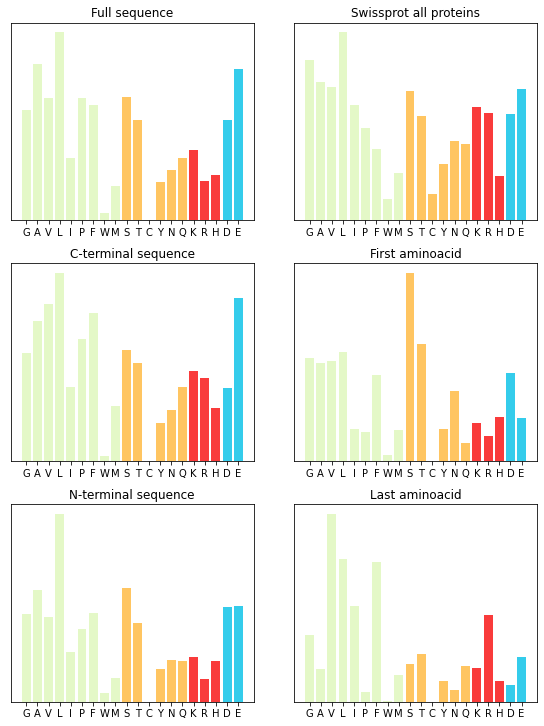

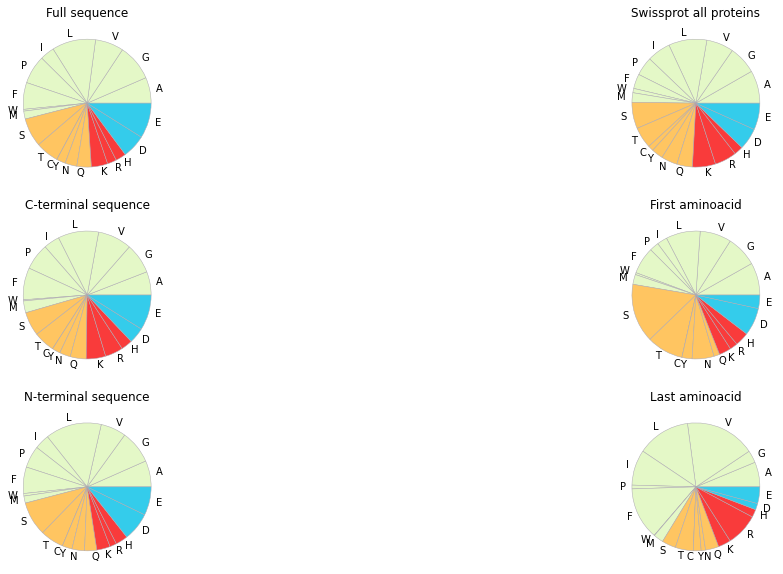

In [31]:

color=['#e4f8c7', '#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#f93b3b','#f93b3b','#f93b3b','#34cceb','#34cceb','#34cceb']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')

fig.savefig('WF_pie.svg', transparent=True, bbox='tight')

## Graph of aminoacid frequency in complete sequences

### How does feature and count correlate in these samples? Are there certain peptides with abnormal feature?

[ 5.83630578 -2.05895298]
0.6928942160318461


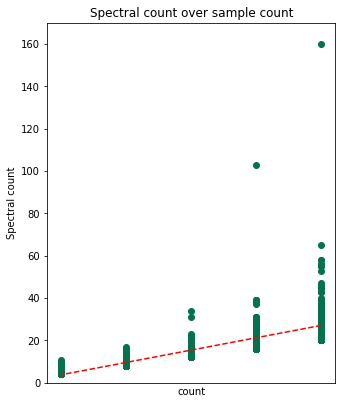

In [154]:
fig=plt.figure(figsize=(4,5), frameon=False)
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#04724d')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over sample count')
plt.plot(df['count'],p(df['count']),"r--")
plt.setp(ax, ylim=(0,170))
ax.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
#plt.savefig('SPC_WF.svg',bbox_inches='tight', transparent=True)


correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [72]:
df.sort_values(['Spectral count'], ascending=False)[0:5].to_clipboard()

### What are the most frequent N,C-terminals and what is their sequence? 


In [35]:

df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_C

,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,std
C-cut,,,,,,,,
KGEE,55.4,58.0,56.0,60.0,41.0,62.0,45,8.354639
RMFL,52.8,56.0,48.0,79.0,24.0,57.0,38,19.791412
FERI,48.8,50.0,57.0,37.0,35.0,65.0,42,12.853015
GEFV,45.2,48.0,46.0,57.0,42.0,33.0,47,8.757854
PDHA,41.0,50.0,59.0,44.0,25.0,27.0,28,14.713939
...,...,...,...,...,...,...,...,...
NGTV,0.8,4.0,0.0,0.0,0.0,0.0,1,1.788854
EQGR,0.8,0.0,4.0,0.0,0.0,0.0,1,1.788854
NELR,0.8,0.0,0.0,0.0,0.0,4.0,1,1.788854


1210
1072


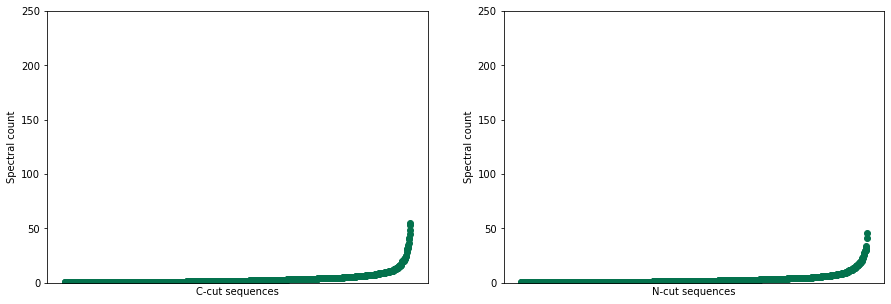

In [36]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
plt.setp(ax, ylim=(0,250))
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))
#fig.savefig('N,C-cut_WF.svg', transparent=True)

### What are the most frequent groups of AA at the N,C-terminal? Are there any combinations?

In [37]:
df_N= df.groupby(['N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['Spectral count'], ascending=False) #sorts these values by count and feature
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C = df_C.sort_values(['Spectral count'], ascending=False)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.groupby(['C-grouped']).sum()
df_C['Spectral count']=df_C['Spectral count']/number_of_files

df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_C

,Mass,Length,RT,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,std
C-grouped,,,,,,,,,,,
NNNN,168863.771400,1572.0,8422.455583,265.8,265.0,254.0,293.0,178.0,337.0,254,59197.500639
NPNN,153651.779500,1414.0,7700.617667,189.4,217.0,292.0,163.0,125.0,150.0,211,53878.309640
NABN,105821.585653,931.0,4183.755000,176.8,181.0,222.0,158.0,102.0,220.0,164,37136.425615
NANN,127051.698900,1167.0,7431.154500,145.4,153.0,164.0,165.0,125.0,120.0,163,44519.650439
PNNN,92620.810500,850.0,5287.489167,121.6,106.0,154.0,103.0,87.0,158.0,144,32454.726675
...,...,...,...,...,...,...,...,...,...,...,...
BPPP,1811.851000,21.0,13.190000,0.8,0.0,0.0,4.0,0.0,0.0,1,638.704443
NPBP,1841.890700,16.0,22.950000,0.8,0.0,0.0,0.0,4.0,0.0,1,649.096294
NBAP,2174.121800,20.0,117.450000,0.8,0.0,0.0,0.0,0.0,4.0,1,762.587888


169
167


,Mass,Length,RT,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,std
C-grouped,,,,,,,,,,,
AAAN,1393.588500,12.0,77.690000,0.8,0.0,4.0,0.0,0.0,0.0,1,488.698706
ABAN,1218.609100,10.0,14.540000,0.8,0.0,0.0,0.0,0.0,4.0,1,429.436997
AAPB,1179.613500,10.0,36.410000,0.8,0.0,0.0,0.0,0.0,4.0,1,414.696097
BBPN,1158.557000,9.0,16.190000,0.8,4.0,0.0,0.0,0.0,0.0,1,408.178982
PPAA,1268.592400,11.0,115.790000,0.8,0.0,0.0,4.0,0.0,0.0,1,443.699885
...,...,...,...,...,...,...,...,...,...,...,...
PNNN,92620.810500,850.0,5287.489167,121.6,106.0,154.0,103.0,87.0,158.0,144,32454.726675
NANN,127051.698900,1167.0,7431.154500,145.4,153.0,164.0,165.0,125.0,120.0,163,44519.650439
NABN,105821.585653,931.0,4183.755000,176.8,181.0,222.0,158.0,102.0,220.0,164,37136.425615


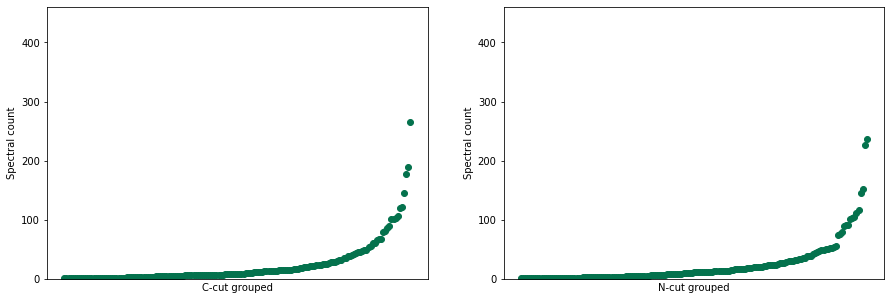

In [347]:

df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))
fig.savefig('N,C-cut_WF_G.svg', transparent=True)
df_C

# Infected samples start here

In [21]:
mapp='peptide_sample_inf'

files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))
    
    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))
    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])


df['Spectral count']=df['#Feature']
df['Spectral count Sample 31']= df['#Feature Sample 31']
df['Spectral count Sample 34']=df['#Feature Sample 34']
df['Spectral count Sample 39']=df['#Feature Sample 39']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count Sample 31','Spectral count Sample 34', 'Spectral count Sample 39','count', 'N-cut', 'C-cut', 'First aa', 'Last aa']]

df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['Spectral count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['Spectral count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['Spectral count'])
First_aa=get_letter_frequency(df['First aa']*df['Spectral count'])
Last_aa=get_letter_frequency(df['Last aa']*df['Spectral count'])

print("Standard deviation TOTAL: "+str(np.std(stdev_tot, ddof=1)))
print("Standard deviation unmod and feat>=4: "+ str(np.std(stdev_amount, ddof=1)))
print("Standard deviation length: "+ str(np.std(stdev_length, ddof=1)))
print("Standard deviation mass: "+ str(np.std(stdev_mass, ddof=1)))
print("Standard deviation protein: "+str(np.std(stdev_protein, ddof=1)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))

print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))

df
print(aminoacids)

# peptides in peptide_sample_31.xlsx 5103
# of peptides with feat>=4 in peptide_sample_31.xlsx: 884
# peptides in peptide_sample_34.xlsx 1412
# of peptides with feat>=4 in peptide_sample_34.xlsx: 196
# peptides in peptide_sample_39.xlsx 4929
# of peptides with feat>=4 in peptide_sample_39.xlsx: 1056
Standard deviation TOTAL: 1700.4262864221887
Standard deviation unmod and feat>=4: 371.5624667087173
Standard deviation length: 1.3133418080983053
Standard deviation mass: 143.02792515872835
Standard deviation protein: 23.612614331233114
Average length: 13.4072553045859
Average mass: 1459.3089345653661
# of peptides in all files: 11444
# of unique peptides: 6483
# peptides with feature>=4: 1461, in percent: 22.535863026376678 %
# of proteins: 103
{'A': 25830, 'G': 15748, 'V': 16709, 'L': 19429, 'I': 1358, 'P': 9455, 'F': 7276, 'W': 1771, 'M': 2893, 'S': 11118, 'T': 9815, 'C': 0, 'Y': 4603, 'N': 6779, 'Q': 2970, 'K': 13965, 'R': 4746, 'H': 11641, 'D': 11265, 'E': 11340}


{'A': 25830, 'G': 15748, 'V': 16709, 'L': 19429, 'I': 1358, 'P': 9455, 'F': 7276, 'W': 1771, 'M': 2893, 'S': 11118, 'T': 9815, 'C': 0, 'Y': 4603, 'N': 6779, 'Q': 2970, 'K': 13965, 'R': 4746, 'H': 11641, 'D': 11265, 'E': 11340}


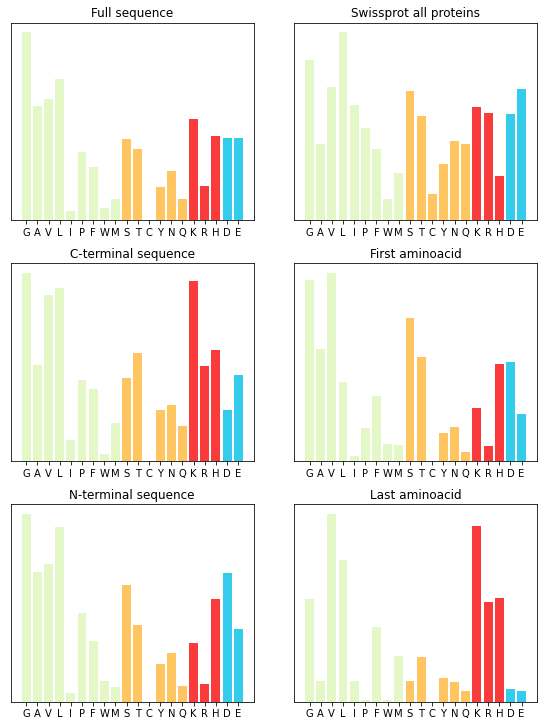

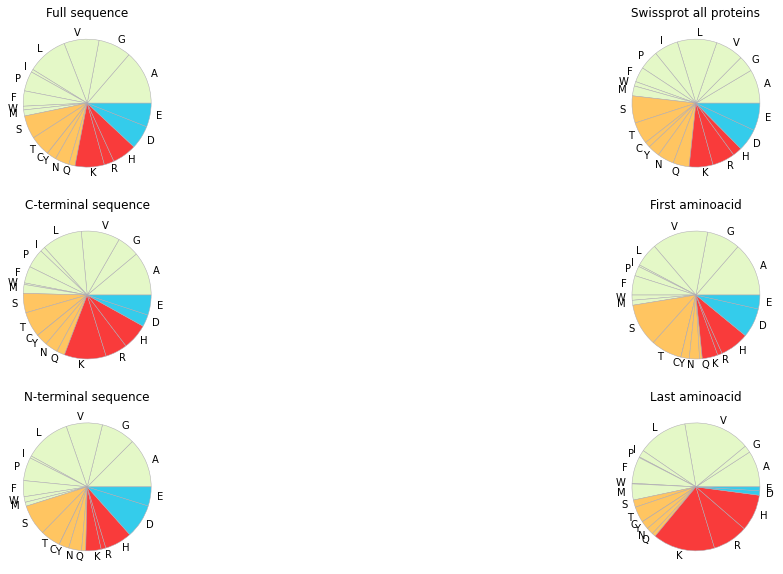

In [27]:

color=['#e4f8c7', '#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#f93b3b','#f93b3b','#f93b3b','#34cceb','#34cceb','#34cceb']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), aminoacids.values(), label=aminoacids.keys(),  align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')

print(aminoacids)
#fig.savefig('INF_pie.svg', transparent=True, bbox='tight')

[10.35027083 -5.55043018]
0.4688525183089574


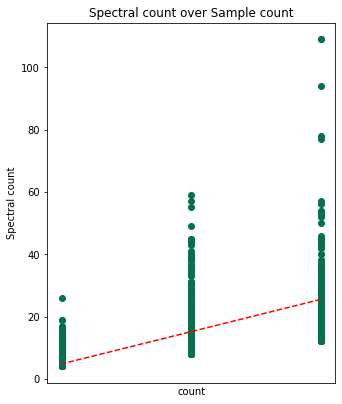

In [134]:
fig=plt.figure(figsize=(4,5))
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#04724d')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over Sample count')
fig.savefig('SPC_INF.svg',transparent=True)

ax.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.savefig('SPC_INF.svg',bbox_inches='tight', transparent=True)

correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [74]:
df.sort_values(['Spectral count'], ascending=False)[0:5].to_clipboard()

In [18]:

df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_C

,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,std
C-cut,,,,,,
HKYH,241.333333,225.0,49.0,450.0,40,200.998342
LERM,170.000000,215.0,9.0,286.0,32,143.878421
SKYR,130.333333,105.0,40.0,246.0,35,105.310652
LSAL,124.666667,131.0,28.0,215.0,34,93.660735
GTFA,113.333333,141.0,20.0,178.0,35,82.637764
...,...,...,...,...,...,...
LVLI,1.333333,4.0,0.0,0.0,1,2.309401
LTNA,1.333333,4.0,0.0,0.0,1,2.309401
LTKY,1.333333,0.0,0.0,4.0,1,2.309401


610
586


,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,std
C-cut,,,,,,
NIKF,1.333333,0.0,0.0,4.0,1,2.309401
IIEI,1.333333,0.0,0.0,4.0,1,2.309401
IIPT,1.333333,4.0,0.0,0.0,1,2.309401
ILEL,1.333333,0.0,0.0,4.0,1,2.309401
INVK,1.333333,0.0,0.0,4.0,1,2.309401
...,...,...,...,...,...,...
GTFA,113.333333,141.0,20.0,178.0,35,82.637764
LSAL,124.666667,131.0,28.0,215.0,34,93.660735
SKYR,130.333333,105.0,40.0,246.0,35,105.310652


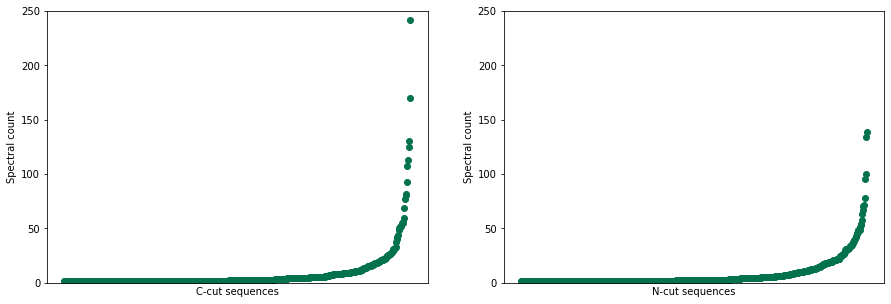

In [363]:

df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')

fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.setp(ax, ylim=(0,250))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))
fig.savefig('N,C-cut_INF.svg', transparent=True)
df_C

In [364]:


df_N= df.groupby(['N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['Spectral count'], ascending=False) #sorts these values by count and feature
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C= df.groupby(['C-cut']).sum()
df_C = df_C.sort_values(['Spectral count'], ascending=False)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.groupby(['C-grouped']).sum()
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_N

,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,std
N-grouped,,,,,,
NNPN,241.666667,311.0,64.0,350.0,89,155.094595
NNBN,222.333333,305.0,34.0,328.0,95,163.506371
NNNB,208.666667,253.0,50.0,322.0,84,141.394248
NBNP,192.000000,222.0,57.0,297.0,73,122.780292
PPNN,175.333333,223.0,40.0,263.0,61,118.896313
...,...,...,...,...,...,...
NABP,1.333333,0.0,0.0,4.0,1,2.309401
PAAP,1.333333,0.0,0.0,4.0,1,2.309401
NAPA,1.333333,4.0,0.0,0.0,1,2.309401


159
149


,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,std
N-grouped,,,,,,
AAAA,1.333333,0.0,0.0,4.0,1,2.309401
APAN,1.333333,0.0,0.0,4.0,1,2.309401
PNPB,1.333333,0.0,0.0,4.0,1,2.309401
NPAB,1.333333,4.0,0.0,0.0,1,2.309401
ANAA,1.333333,4.0,0.0,0.0,1,2.309401
...,...,...,...,...,...,...
PPNN,175.333333,223.0,40.0,263.0,61,118.896313
NBNP,192.000000,222.0,57.0,297.0,73,122.780292
NNNB,208.666667,253.0,50.0,322.0,84,141.394248


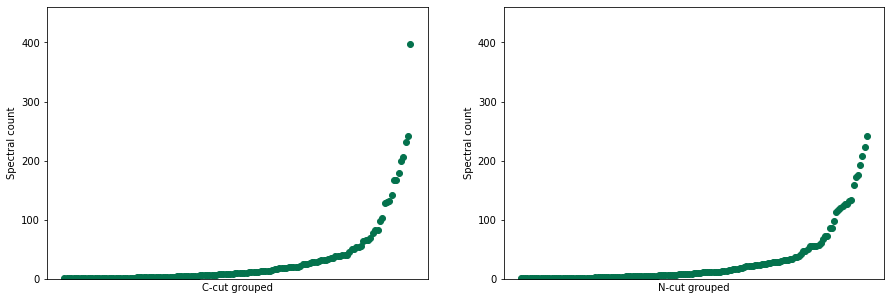

In [365]:

df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))
fig.savefig('N,C-cut_INF-G.svg', transparent=True)
df_N

# Non-infected samples start here

In [28]:
mapp='peptide_sample_ninf'

files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))
    
    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))
    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data

df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])

df['Spectral count']=df['#Feature']
df['Spectral count Sample 13']=df['#Feature Sample 13']
df['Spectral count Sample 21']=df['#Feature Sample 21']
df['Spectral count Sample 33']=df['#Feature Sample 33']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count Sample 13','Spectral count Sample 21', 'Spectral count Sample 33','count', 'N-cut', 'C-cut','First aa','Last aa']]

df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['Spectral count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['Spectral count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['Spectral count'])
First_aa=get_letter_frequency(df['First aa']*df['Spectral count'])
Last_aa=get_letter_frequency(df['Last aa']*df['Spectral count'])


print("Standard deviation TOTAL: "+str(np.std(stdev_tot, ddof=1)))
print("Standard deviation unmod and feat>=4: "+ str(np.std(stdev_amount, ddof=1)))
print("Standard deviation length: "+ str(np.std(stdev_length, ddof=1)))
print("Standard deviation mass: "+ str(np.std(stdev_mass, ddof=1)))
print("Standard deviation protein: "+str(np.std(stdev_protein, ddof=1)))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))

print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))

df
print(aminoacids)

# peptides in peptide_sample_13.xlsx 3146
# of peptides with feat>=4 in peptide_sample_13.xlsx: 264
# peptides in peptide_sample_21.xlsx 4863
# of peptides with feat>=4 in peptide_sample_21.xlsx: 433
# peptides in peptide_sample_33.xlsx 4277
# of peptides with feat>=4 in peptide_sample_33.xlsx: 756
Standard deviation TOTAL: 712.6356401103972
Standard deviation unmod and feat>=4: 204.11162523373224
Standard deviation length: 0.7135337024249243
Standard deviation mass: 70.57035850341384
Standard deviation protein: 19.871811414385174
Average length: 12.06831119544592
Average mass: 1319.4200671041535
# of peptides in all files: 12286
# of unique peptides: 7013
# peptides with feature>=4: 1054, in percent: 15.029231427349208 %
# of proteins: 124
{'A': 10432, 'G': 8373, 'V': 6973, 'L': 9871, 'I': 1734, 'P': 7132, 'F': 3372, 'W': 403, 'M': 1443, 'S': 6672, 'T': 4496, 'C': 0, 'Y': 1437, 'N': 3442, 'Q': 2458, 'K': 5442, 'R': 3828, 'H': 5691, 'D': 6012, 'E': 7359}


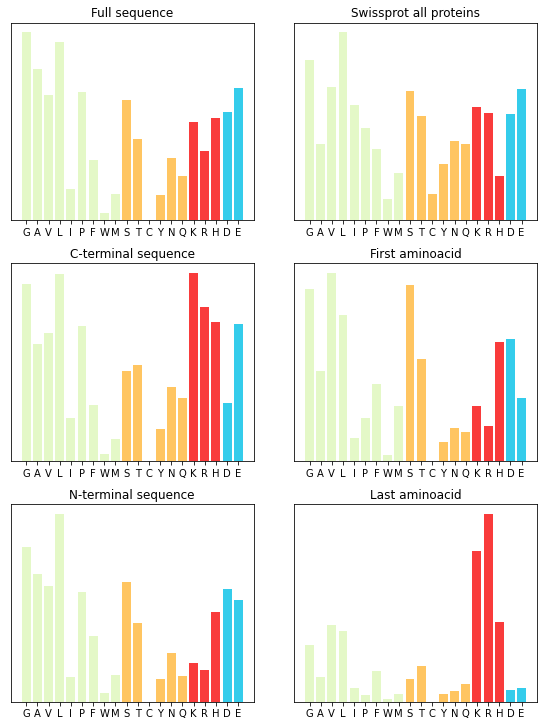

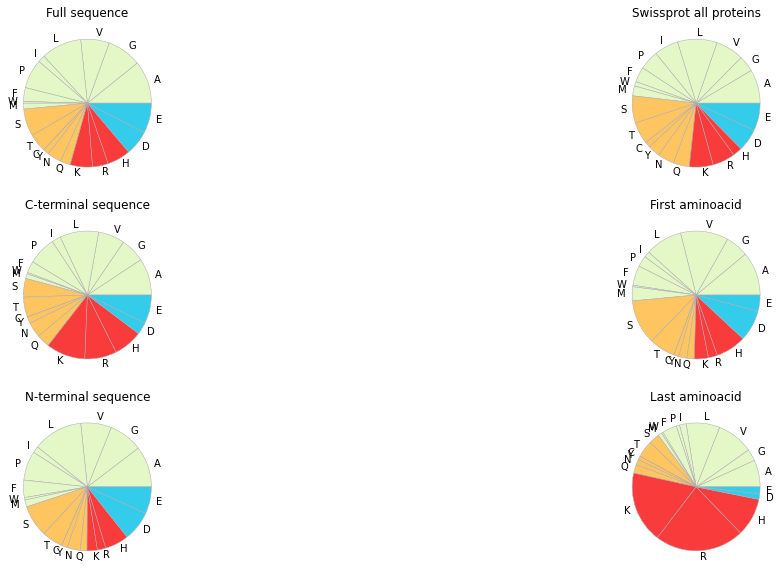

In [16]:

color=['#e4f8c7', '#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#f93b3b','#f93b3b','#f93b3b','#34cceb','#34cceb','#34cceb']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')


fig.savefig('NINF_pie.svg', transparent=True, bbox='tight')

[ 7.26228405 -2.55701967]
0.5612248944032844


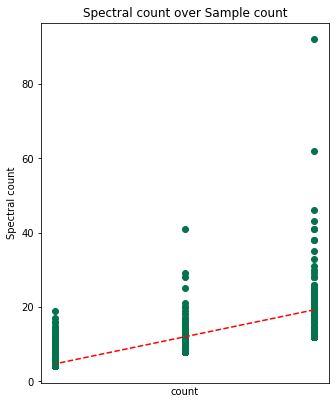

In [66]:
fig=plt.figure(figsize=(4,5))
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#04724d')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over Sample count')
fig.savefig('SPC_NINF.svg',transparent=True)

ax.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.savefig('SPC_NINF.svg',bbox_inches='tight', transparent=True)

correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [76]:
df.sort_values(['Spectral count'], ascending=False)[0:5].to_clipboard()

In [357]:

df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_C

,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,std
C-cut,,,,,,
LHAH,109.666667,139.0,161.0,27.0,37,71.860977
HKYH,83.666667,64.0,60.0,127.0,21,37.581024
ALER,57.666667,59.0,55.0,59.0,28,2.309401
MPNA,56.666667,50.0,58.0,62.0,22,6.110101
EITR,54.000000,32.0,65.0,64.0,12,18.770544
...,...,...,...,...,...,...
EKSA,1.333333,4.0,0.0,0.0,1,2.309401
LVQT,1.333333,0.0,0.0,4.0,1,2.309401
LVEV,1.333333,0.0,4.0,0.0,1,2.309401


602
553


,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,std
C-cut,,,,,,
YVYK,1.333333,0.0,0.0,4.0,1,2.309401
TAHR,1.333333,0.0,0.0,4.0,1,2.309401
TAAL,1.333333,0.0,0.0,4.0,1,2.309401
SYNR,1.333333,0.0,4.0,0.0,1,2.309401
QAQR,1.333333,0.0,0.0,4.0,1,2.309401
...,...,...,...,...,...,...
EITR,54.000000,32.0,65.0,64.0,12,18.770544
MPNA,56.666667,50.0,58.0,62.0,22,6.110101
ALER,57.666667,59.0,55.0,59.0,28,2.309401


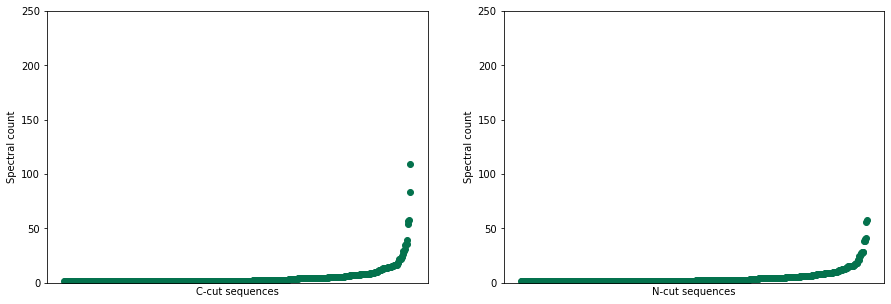

In [358]:

df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')

fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.setp(ax, ylim=(0,250))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))
fig.savefig('N,C-cut_NINF.svg', transparent=True)
df_C

In [359]:


df_N= df.groupby(['N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['Spectral count'], ascending=False) #sorts these values by count and feature
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C= df.groupby(['C-cut']).sum()
df_C = df_C.sort_values(['Spectral count'], ascending=False)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.groupby(['C-grouped']).sum()
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files

df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_N

,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,std
N-grouped,,,,,,
NNNN,153.333333,77.0,157.0,226.0,87,74.567643
NNNP,99.000000,58.0,104.0,135.0,45,38.742741
NNBN,98.000000,43.0,45.0,206.0,48,93.536089
NNPN,88.333333,56.0,70.0,139.0,47,44.433471
NNNB,88.000000,47.0,85.0,131.0,45,42.063444
...,...,...,...,...,...,...
PAPA,1.333333,0.0,0.0,4.0,1,2.309401
PBAN,1.333333,0.0,4.0,0.0,1,2.309401
PBBP,1.333333,0.0,0.0,4.0,1,2.309401


150
162


,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,std
N-grouped,,,,,,
AAAP,1.333333,0.0,0.0,4.0,1,2.309401
AAPP,1.333333,0.0,0.0,4.0,1,2.309401
AANP,1.333333,0.0,0.0,4.0,1,2.309401
AANB,1.333333,0.0,0.0,4.0,1,2.309401
ANAA,1.333333,0.0,4.0,0.0,1,2.309401
...,...,...,...,...,...,...
NNNB,88.000000,47.0,85.0,131.0,45,42.063444
NNPN,88.333333,56.0,70.0,139.0,47,44.433471
NNBN,98.000000,43.0,45.0,206.0,48,93.536089


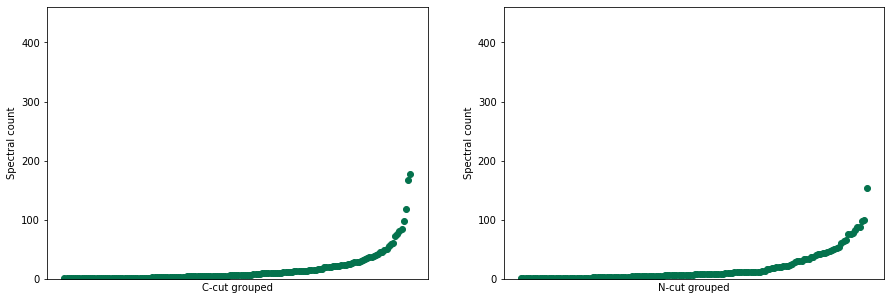

In [360]:

df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))
fig.savefig('N,C-cut_NINF-G.svg', transparent=True)
df_N